In [1]:
# Import necessary libraries
using AlgebraicRelations.DB, 
      AlgebraicRelations.Queries, 
      AlgebraicRelations.Interface, 
      AlgebraicRelations.Presentations;

## Define the Schema
We need to define the data types, the table column names, and the syntax of our schema

In [2]:
# Initialize presentation object
present = Presentation()

# Add types to presentation
Person, ID, Name, Salary = add_types!(present, [(:Person, Int),
                                          (:ID, Int),
                                          (:Name, String),
                                          (:Salary, Real)]);

# Add Processes to presentation
get_employees, get_manager,
get_salary, get_name = add_processes!(present, [(:get_employees, Person, ID),
                                                (:get_manager, Person, Person),
                                                (:get_salary, Person, Salary),
                                                (:get_name, Person, Name)]);


Workplace = present_to_schema(present)
schema = Workplace();

In [3]:
print(generate_schema_sql(schema));

CREATE TABLE get_manager (Person1 int, Person2 int);
CREATE TABLE get_name (Person1 int, Name2 text);
CREATE TABLE get_employees (Person1 int, ID2 int);
CREATE TABLE get_salary (Person1 int, Salary2 real);

## Generate the Query
We are now able to generate queries based off of this schema which we defined.

SELECT t1.Name2 AS emp_name, t2.Salary2 AS salary
FROM get_name AS t1, get_salary AS t2
WHERE t2.Person1=t1.Person1 AND t2.Salary2<=$2 AND t2.Salary2>=$1

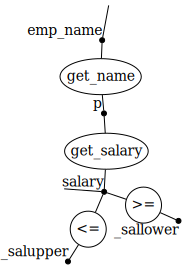

In [4]:
# We generate a query that gets all employees make a salary within some range
q1 = @query schema (emp_name, salary) where 
                          (p, emp_name, 
                           salary,
                           _sallower, _salupper) begin                       
  # Define name relationships
  get_name(p, emp_name)
  
  # Define salary relationships (with input range)
  get_salary(p,salary)
  <=(salary, _salupper)
  >=(salary, _sallower)
end;
print(to_sql(q1))
draw_query(q1)

SELECT t1.Name2 AS emp_name, t2.Name2 AS man_name, t4.Salary2 AS salary
FROM get_name AS t1, get_name AS t2, get_manager AS t3, get_salary AS t4
WHERE t3.Person1=t1.Person1 AND t3.Person2=t2.Person1 AND t4.Person1=t2.Person1 AND t4.Salary2<=$2 AND t4.Salary2>=$1

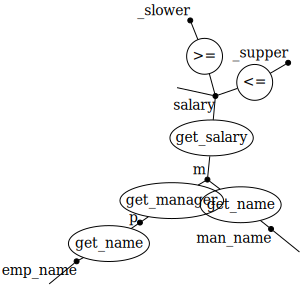

In [5]:
# We generate a second query that gets all employees whose managers make a salary within some range
q2 = @query schema (emp_name, man_name,salary) where 
                          (p, m, emp_name, 
                           man_name, salary, 
                           _slower, _supper) begin                       
  # Define name relationships
  get_name(p, emp_name)
  get_name(m, man_name)
  
  # Define manager relationships
  get_manager(p,m)
    
  # Define salary relationships (with input range)
  get_salary(m,salary)
  <=(salary, _supper)
  >=(salary, _slower)
end;
print(to_sql(q2))
draw_query(q2)